# Granite ReAct Agent

##### Building a Granite ReAct Agent on watsonx.ai™

In this tutorial, you will learn how to use the **ReAct (Reason + Act)** design pattern with an IBM® [Granite](https://www.ibm.com/granite) 4 model on [watsonx.ai™](https://www.ibm.com/products/watsonx-ai) to perform dynamic **tool calling**. 

You will:
1. Understand what the ReAct pattern is and when to use it.  
2. Connect a Granite model hosted on watsonx.ai.  
3. Define tools the model can call.  
4. Implement the reasoning–action–observation loop.  
5. Run an end-to-end example for a **travel planning assistant**.

> **Estimated time:** 20 minutes  
> **Prerequisites:** watsonx.ai credentials and environment variables `WATSONX_URL`, `WATSONX_APIKEY`, and `WATSONX_PROJECT_ID` set in your environment.

## 1. What is ReAct?

**ReAct** stands for **Reason + Act**.  
It is a design pattern that lets an LLM alternate between reasoning about what to do next (“Thought”) and taking actions using external tools (“Action”) until it reaches a final answer.

Each reasoning loop typically follows this structure:

```

Thought → Action → Observation → Thought → ... → Answer

ReAct enables the model to adapt dynamically to intermediate results — ideal when:
- The model must decide *which tools to use* and *in what order*.  
- The task cannot be expressed as a simple, deterministic pipeline.  
- The model benefits from iterative reasoning and external knowledge.

For deterministic workflows, such as simple API wrappers or rule-based steps, a fixed flow is still preferable.  
ReAct shines in cases where flexible, context-dependent decisions are needed.

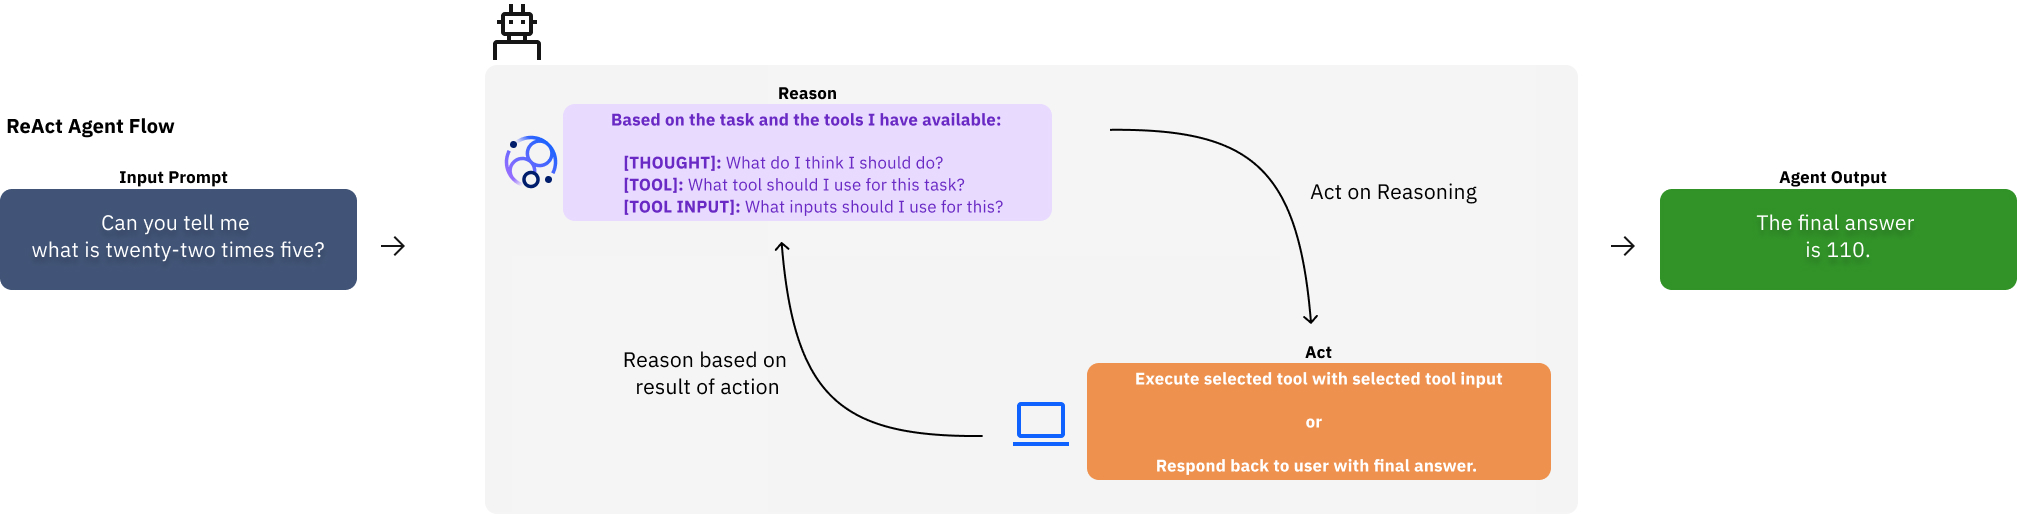

## 2. Environment Setup

This notebook can be run locally or in watsonx.ai Notebooks.  

We'll start by installing dependencies.  
- `langgraph` orchestrates the reasoning loop as a graph of nodes.  
- `langchain_ibm` provides watsonx.ai model integration.  
- `ibm-granite-community/utils` gives helper utilities for managing environment variables.

> To avoid dependency conflicts, consider using a virtual environment or conda environment with Python ≥ 3.11.

In [ ]:
! echo "::group::Install Dependencies"
%pip install uv
! uv pip install "git+https://github.com/ibm-granite-community/utils.git" \
    langgraph \
    langchain \
    langchain_ibm
! echo "::endgroup::"


## 3. Connect to Granite on watsonx.ai™

Next, we initialize a **Granite 4 model** using the LangChain `init_chat_model()` helper.  
This connects securely to your watsonx.ai instance using your API key and project ID.

See [Getting Started with IBM watsonx](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started/Getting_Started_with_WatsonX.ipynb) for information on getting ready to use watsonx.ai. 

You will need three credentials from the watsonx.ai set up to add to your environment: `WATSONX_URL`, `WATSONX_APIKEY`, and `WATSONX_PROJECT_ID`.

You will be prompted to enter your credentials if they are not already stored as environment variables.  
These credentials can also be retrieved automatically from `.env` files or secret stores via `get_env_var()`.

In [ ]:
from ibm_granite_community.notebook_utils import get_env_var
from langchain_core.utils.utils import convert_to_secret_str
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage

model = "ibm/granite-4-h-small"

model_parameters = {
    "temperature": 0,
    "max_completion_tokens": 500,
    "repetition_penalty": 1.05,
    "stop": ["Observation:", "\nObservation:", " Observation:"],
}

llm = init_chat_model(
    model=model,
    model_provider="ibm",
    url=convert_to_secret_str(get_env_var("WATSONX_URL")),
    apikey=convert_to_secret_str(get_env_var("WATSONX_APIKEY")),
    project_id=get_env_var("WATSONX_PROJECT_ID"),
    params=model_parameters,
)

## 4. Define tools

Tools are the LLM's interfaces to the digital world. Just as well-defined and described tools enable humans to select and use the right tool for the job, a similarly well-defined toolset can enable the LLM or Agent to be more accurate in its execution.

To improve the liklihood of the relevant tools being selected by the ReAct algorithm, all possible tools that an LLM can choose from should:
- Have a **clear, descriptive name** (e.g., `get_weather`).
- Have **well-defined uses and applications**, specified through semantic descriptions of the tools.
- Be accompanied with a **clear and descriptive** parameter schema, with descriptions for each parameter.
- Return a **simple text output** that the model can read as context for the next step.

To further improve the changes of accurate operation, developers should consider toolsets which are narrow, and non-overlapping so that there is clarity for the LLM when choosing the action.


Here we define three mock travel-related tools:
- `get_weather` — returns a climate description for a given city and month.  
- `get_flight_info` — returns average flight prices.  
- `get_hotel_prices` — returns average hotel ranges.

In [ ]:
from langchain.tools import tool

@tool
def get_weather(destination: str, month: str) -> str:
    """Get weather for a destination and month."""
    return f"The weather in {destination} in {month} is cool and dry, highs ~16°C."

@tool
def get_flight_info(destination: str, month: str) -> str:
    """Get flight cost for a destination and month."""
    return f"Flights to {destination} in {month} average around $1200 USD round-trip."

@tool
def get_hotel_prices(destination: str, month: str) -> str:
    """Get hotel prices for a destination and month."""
    return f"Hotels in {destination} range from $100 to $300 per night in {month}."

tools = [get_weather, get_flight_info, get_hotel_prices]


In [ ]:
tool_descriptions = "\n".join([f"- {t.name}: {t.description}" for t in tools])
tool_names = ", ".join([t.name for t in tools])

## 5. Write the ReAct system instructions

Next, we craft a **system prompt** that teaches the model the ReAct workflow.

This prompt:
- Defines the available tools.  
- Demonstrates the *Thought → Action → Observation → Answer* pattern.  
- Specifies strict formatting rules to ensure one tool is called at a time.  
- Instructs the model to **wait** for an observation before continuing reasoning.

This explicit, step-by-step example helps smaller models like Granite 4-small stay consistent and avoids hallucinating multiple actions.

In [ ]:
react_instructions = f"""
You are a helpful travel planning assistant that uses the ReAct (Reasoning + Acting) framework to answer travel-related questions.

Always reason step by step in a visible loop of **Thought → Action  → Observation**.
When finished, output the **Answer**.

Tool Usage
Available Tools to you:
{tool_descriptions}

You MUST use the following format to answer the user's travel related question, using the list of tools as needed:

Thought: <Explain thoughts and action to take>
Action: {{"name": "tool_name", "args": {{"destination": "...", "month":"..."}}}}
Observation: (filled later with the tool result)
(This loop may repeat multiple times, until you know the final answer)
Thought: I know the final answer.
Answer: <final answer to the user>

Example Format

User: I want to visit Paris in May. How much should that cost?
Thought: The user wants travel advice. I should check the hotel prices
Action: {{"name": "get_hotel_prices", "args": {{"destination": "Paris", "month": "May"}}
Observation: Hotel prices are between $250-500.
Thought: Next I need to check the price of flights
Action: {{"name": "get_flight_info, "args": {{"destination": "Paris", "month": "May"}}
Observation: Flight to Paris in May are $500.
Thought: I know the final answer.
Answer: Travel to Paris is good this time of year. Hotel prices are between $250-500 and flight tickets are around $500


Rules
* Always show each step begging with "Thought:" on it's own line BEFORE performing any actions.
* YOU MUST make only ONE Action at a time per loop
* NEVER propose multiple Actions together.
* After performing ONE Action, WAIT for the Observation before reasoning again
* DO NOT Write Observation yourself. Only the system will provide Observation after your Action
* Only use tools listed in "Available Tools", which are the following: {tool_names}
* Stop ONLY when you reach the final Answer
* NEVER include Final Answer in the same turn as an Action. If you just took an Action, wait for an Observation first.
* If you think no Action is needed, just output Answer, do not generate a JSON Action.
* Only use tools these tools: {tool_names}
"""



## 6. Implement the ReAct loop with LangGraph

We now implement the reasoning loop using `langgraph`.

Each iteration:
1. Sends the current messages (system + chat history) to the model.  
2. Extracts any JSON action object (`{"name": "...", "args": {...}}`).  
3. Executes the selected tool and captures its result as an **Observation**.  
4. Appends the Observation to the message history.  
5. Repeats until the model outputs a final **Answer**.

This is a lightweight, framework-agnostic implementation of the ReAct pattern described further in the [Granite Understanding ReAct tutorial](https://github.com/ibm-granite-community/granite-snack-cookbook/blob/main/recipes/ReAct/Understanding_ReAct.ipynb).

In [ ]:
class AgentState(TypedDict, total=False):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
import json

def call_model(state: AgentState):
    """Single ReAct reasoning step without regex loops.
    Extracts everything between the first '{' and the last '}' after Action:.
    """
    messages: list[AnyMessage] = [SystemMessage(content=react_instructions), *state.get("messages", [])]
    ai = llm.invoke(messages)
    output_text = (ai.text or "").strip()
    print('💭 ' + output_text)

    # --- extract Action JSON using first '{' and last '}' slice ---
    if "Action:" in output_text:
        # Grab everything after "Action:" and between outer braces
        raw_action = output_text.split("Action:", 1)[-1]
        start = raw_action.find("{")
        end = raw_action.rfind("}") + 1
        if start != -1 and end != -1:
            raw_action = raw_action[start:end]
        else:
            raw_action = None

        if raw_action:
            try:
                # Clean up single quotes if model uses them
                cleaned = raw_action.replace("'", '"')
                action = json.loads(cleaned)

                tool_name = action.get("name")
                args = action.get("args", {}) or {}
                tool = next((t for t in tools if t.name == tool_name), None)

                if tool:
                    obs = tool.invoke(args)
                    print(f"🔎 Observation: {obs}\n{'-'*70}\n")
                    # Feed observation back into conversation
                    return {"messages": [ai, ("user", f"Observation: {obs}")]}
                else:
                    print(f"Unknown tool: {tool_name}")
            except Exception as e:
                print(f"Failed to parse Action JSON: {e}")
                return {"messages": [ai]}  # fail-safe end

    # --- detect final Answer ---
    if "Answer:" in output_text:
        print("\n✅ Final Answer reached.\n")
        return {"messages": [ai]}

    # --- safety fallback ---
    print("No Action/Answer detected; ending to avoid loop.\n")
    return {"messages": [ai]}


In [ ]:
def route_from_llm(state: AgentState):
    messages = state.get("messages", [])
    last = messages[-1]
    if isinstance(last, AIMessage):
        txt = (last.text or "")
        # Final answer ends the run
        if "Answer:" in txt:
            return "end"
        # No Action and no Answer → end (prevents infinite loop)
        return "end"
    else:
        # A tuple like ("user", "Observation: ...") → continue to llm
        return "llm"

## 7. Run the ReAct agent

Now let’s test our **travel-planning assistant** with a sample query.

The model should:
1. Think through the problem (reason).  
2. Choose a tool (act).  
3. Wait for the Observation (feedback).  
4. Continue until it produces a final Answer summarizing all gathered details.

Try adjusting the city or month to see how the model dynamically changes which tools it calls and in what order.

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_model)
graph.add_edge(START, "llm")
graph.add_conditional_edges("llm", route_from_llm, {"llm": "llm", "end": END})
app = graph.compile()


In [ ]:
inputs = AgentState(messages=[HumanMessage(content="I want to visit Tokyo next April. What should I expect about weather and costs?")])
result = app.invoke(inputs)

## 8. Creating a ReAct Agent the Simpler Way

Earlier, we built the full ReAct loop manually — parsing model outputs, calling tools, and feeding back Observations step by step.  
That approach helped illustrate *how* ReAct works, but it required a lot of orchestration code.

With LangChain’s modern API, we can do the same thing in just a few lines.  
The `create_agent()` function builds a ready-to-use ReAct reasoning agent, which runs the entire Thought → Action → Observation → Answer loop automatically.  

This simplified version achieves the same behavior as before but with far less code — cleaner, safer, and easier to extend for real applications.

In [ ]:
from langchain.agents import create_agent

model_parameters = {
    "temperature": 0,
    "max_completion_tokens": 500,
    "repetition_penalty": 1.05,
}

llm = init_chat_model(
    model=model,
    model_provider="ibm",
    url=convert_to_secret_str(get_env_var("WATSONX_URL")),
    apikey=convert_to_secret_str(get_env_var("WATSONX_APIKEY")),
    project_id=get_env_var("WATSONX_PROJECT_ID"),
    params=model_parameters,
)

# Create a ReAct-style agent using the standard LangChain API
agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=react_instructions,
)

A note about the `system_prompt` argument to the `create_agent()` function. Here we provide the same `react_instructions` in the system_prompt field that was used before in order to obtain the same ReAct functionality. If we omit this field, the agent will exhibit the same functionality as the Agent created in the [Function_Calling_Agent notebook](https://github.com/ibm-granite-community/granite-agent-cookbook/blob/main/recipes/Function_Calling/Function_Calling_Agent.ipynb) example.

In [ ]:
response = agent.invoke({
    "messages": [HumanMessage(content="I want to visit Tokyo next month, which will be April. What should I expect in terms of weather and cost?")]
})

print(response["messages"][-1].text)

## Conclusion

`ReAct` is a widely adopted agentic pattern because it integrates reasoning and action in a structured loop, enabling robust decision-making. However, it represents only one approach for buiding agents. Different architectures may be better suited for different problems, some of which we’ve introduced in the [building_agents notebook tutorial](https://github.com/ibm-granite-community/granite-agent-cookbook/blob/main/building_agents.md). It's encouraged to explore this tutorial to become familiarized with additional patterns for appropriate use cases.